# import library

In [69]:
import torch 
import torch.nn as nn 
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import convolve2d
from tqdm.notebook import tqdm_notebook
import random
from sklearn.preprocessing import OneHotEncoder

# Hyperparameters

In [70]:
batchsize = 1024
learning_rate = 0.03
learning_rate_lc = 0.03
epochs = 100
threshold = 3.0
image_shape = (1,28,28)
image_1d_shape = np.prod(image_shape)
layers = [image_1d_shape,500,500,500,500]
softmax_layers = [0,1,2,3]

# Dataset

In [71]:
train_dataset = MNIST("./data/",download=True, train=True, transform=ToTensor())
test_dataset = MNIST("./data/",download=True, train=False, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

In [72]:
def label_to_oh(y):
    y = y.numpy().reshape(-1,1)
    ohe = OneHotEncoder().fit(np.arange(10).reshape((10,1)))
    ohe_y = ohe.transform(y).toarray()
    return torch.Tensor(ohe_y)

In [73]:
def show_image(x):
    x = x.squeeze()
    plt.imshow(x, cmap="gray")
    plt.show()

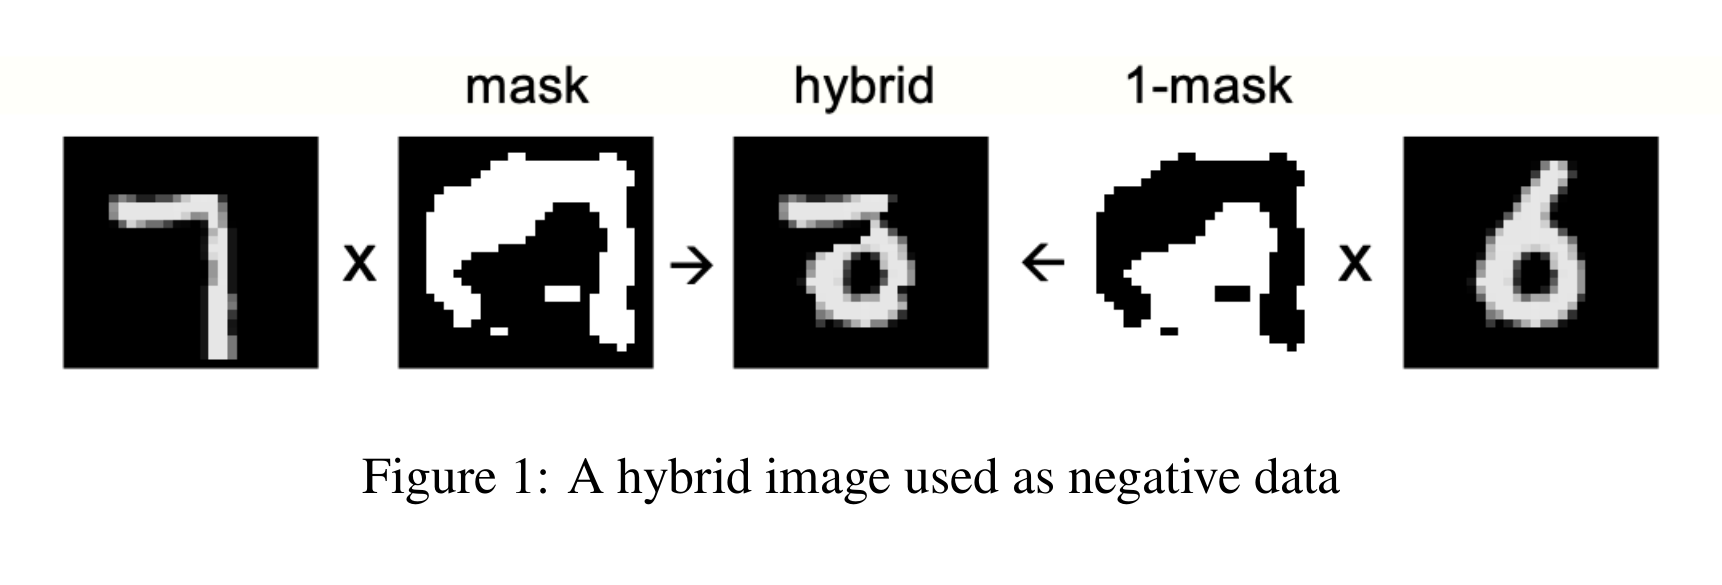

# Generating masks

In [74]:
# The method for generating masks for negative data mentioned by Geoffrey Hinton in the article
def mask_gen():
    random_iter = np.random.randint(5,10)
    random_image = np.random.randint(2, size=image_shape).squeeze().astype(np.float32)
    blur_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    for i in range(random_iter):
        random_image = convolve2d(random_image, blur_filter, mode='same', boundary='symm')
    mask = (random_image > 0.5).astype(np.float32)
    return mask

# The method for creating masks for negative data that I tried for testing purposes.
def mask_gen1():
    n = image_1d_shape
    arr1 = np.random.normal(loc=0, scale=0.01, size=int(5*n/8))
    arr1 = arr1+ abs(0-arr1.min())
    arr2 = np.random.normal(loc=1, scale=0.01, size=int(3*n/8))
    arr2 = arr2 + abs(1-arr2.max())
    arr = np.concatenate([arr1,arr2])
    np.random.shuffle(arr)
    mask = arr.reshape(image_shape).astype(np.float32)
    return mask

# Obtaining the hybrid image by applying the mask

In [75]:
def negative_data_gen(batch):
    batch = batch[0]
    indexes = torch.randperm(batch.shape[0])
    x1 = batch
    x2 = batch[indexes]
    mask = mask_gen()
    merged_x1 = x1*mask
    merged_x2 = x2*(1-mask)
    hybrid_image = merged_x1+merged_x2
    return hybrid_image

# Defining the FF Layer

In [76]:
class FFLayer(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = nn.ReLU()
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.threshold = threshold
        self.epoch_num = epochs
        
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))
    
    def train(self, x_pos,x_neg):
        for i in range(self.epoch_num):
            out_pos = self.forward(x_pos).pow(2).mean(1)
            out_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1+ torch.exp(torch.cat([threshold-out_pos,out_neg-threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


# Defining the FF Network

In [77]:
class FFNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = []
        for i in range(len(layers)-1):
            self.layers.append(FFLayer(layers[i],layers[i+1]).cuda())
    
    def predict(self,x, softmax_layers):
        layers_output = torch.Tensor([]).cuda()
        h = x
        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i in softmax_layers:
                layers_output = torch.cat([layers_output,h],1)
                
        return layers_output
        
    def train(self, x_pos, x_neg):
        out_pos, out_neg = x_pos, x_neg
        layer_loop = tqdm_notebook(enumerate(self.layers), leave=False)
        for i, layer in layer_loop:
            layer_loop.set_description(f"Training Layer: [{i+1}/{len(self.layers)}]")
            out_pos, out_neg = layer.train(out_pos, out_neg)
    


# Training the FF Network

In [78]:
model = FFNet(layers)

model_train_loop = tqdm_notebook(iter(train_loader),leave=True) 
for batch in model_train_loop:
    x_pos = batch[0]
    x_neg = negative_data_gen(batch)
    x_pos, x_neg = x_pos.view(-1,image_1d_shape).cuda(), x_neg.view(-1,image_1d_shape).cuda()
    model.train(x_pos,x_neg)

  0%|          | 0/59 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Defining the Linear Classifier

In [79]:
class LinearClassification(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.epoch_losses = []
        self.linear = torch.nn.Linear(input_dimension, 10).cuda()
        self.optimizer = SGD(self.parameters(), lr=learning_rate_lc)
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax()
        
    def forward(self,x):
        return self.linear(x)
    
    def predict(self,x):
        x = x.view(-1,image_1d_shape).cuda()
        h_activity = model.predict(x,softmax_layers)
        y_h = self.forward(h_activity)
        soft_out = self.softmax(y_h)
        return soft_out.argmax()
        
        
    def train(self, data_loader,epoch_num):
        linear_loop = tqdm_notebook(range(epoch_num),total=epoch_num)
        for i in linear_loop:
            batch_losses = []
            for batch in iter(data_loader):
                x,y = batch
                x = x.view(-1,image_1d_shape).cuda()
                y_r = label_to_oh(y).cuda()
                h_activity = model.predict(x,softmax_layers)
                y_h = self.forward(h_activity)
                loss = self.criterion(y_h,y_r)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_losses.append(loss)
            self.epoch_losses.append(float(sum(batch_losses)/len(batch_losses)))
            linear_loop.set_description(f"Epoch [{i+1}/{epoch_num}]: ")
            linear_loop.set_postfix(loss=self.epoch_losses[i])    
            
    def test(self, data_loader):
        batch_losses = []
        test_loss = 0
        for batch in iter(data_loader):
            x,y = batch
            x = x.view(-1,image_1d_shape).cuda()
            y_r = label_to_oh(y).cuda()
            h_activity = model.predict(x,softmax_layers)
            y_h = self.forward(h_activity)
            loss = self.criterion(y_h,y_r)
            batch_losses.append(loss)
        test_loss = float(sum(batch_losses)/len(batch_losses))
        return test_loss
     
    
    

In [80]:
def neuron_num(layers,softmax_layers):
    num = 0
    layers = layers[1:]
    for i in softmax_layers:
            num += layers[i]
    return num

# Training the Linear Classifier

In [81]:
linear_model = LinearClassification(neuron_num(layers,softmax_layers))
losses = linear_model.train(train_loader,epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
linear_model.test(test_loader)

0.1740536242723465

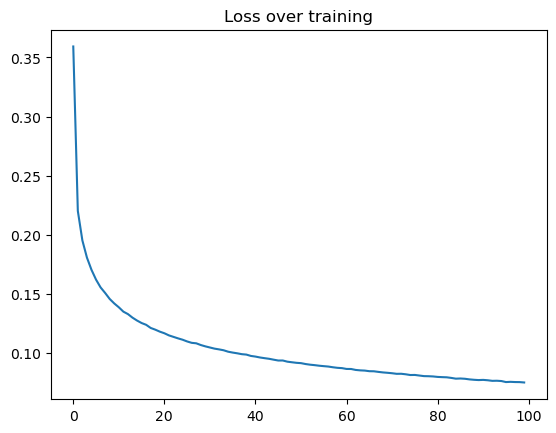

In [83]:
plt.plot(linear_model.epoch_losses)
plt.title("Loss over training")
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5152\3733278961.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_out = self.softmax(y_h)


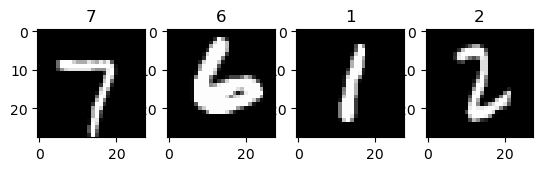

In [88]:
batch = next(iter(test_loader))
n = 4
fig, ax1 = plt.subplots(1, n)
for i in range(n):
    x = batch[0][i]
    num=int(linear_model.predict(x))
    ax1[i].imshow(x.squeeze(),cmap="gray")
    ax1[i].set_title(str(num))
plt.show()